In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm, trange
import scipy.signal
from tensorboardX import SummaryWriter
import time
import pdb
import argparse

# self defined modules
from models import CAE
import utils


def loss_function(recon_x, x): 
    BCE = F.l1_loss(recon_x.view(-1, 1000), x.view(-1, 1000))
    return BCE.cuda()


class raman_dataset(Dataset):
    def __init__(self, file_path, raman_file, cars_file):
        self.raman_data = pd.read_csv(os.path.join(file_path, raman_file)).iloc[:, 1:]
        self.cars_data = pd.read_csv(os.path.join(file_path, cars_file)).iloc[:, 1:]
        
    def __len__(self):
        return len(self.raman_data)

    def __getitem__(self, idx):
        raman_data = self.raman_data.values[idx]
        cars_data = self.cars_data.values[idx]
        return raman_data, cars_data


#select dataset
dataset = 1
if dataset == 1:
    a=1
    b='a'
elif dataset == 2:
    a=1
    b='b'
elif dataset == 3:
    a=1
    b='c'
elif dataset == 4:
    a=2
    b='a'
elif dataset == 5:
    a=2
    b='b'
elif dataset == 6:
    a=2
    b='c'
elif dataset == 7:
    a=3
    b='a'
elif dataset == 8:
    a=3
    b='b'
else:
    a=3
    b='c'
    
    
model_save_dir = os.path.join('trained_model', '{}-skip'.format('cae_8'),'{}-dataset'.format(dataset))    
dataset_val = raman_dataset('data', str(a)+b+'Raman_spectrums_valid.csv', str(a)+b+'CARS_spectrums_valid.csv')

val_loader = DataLoader(dataset_val, batch_size=256, shuffle=False, num_workers=0)
checkpoint_path = os.path.join(model_save_dir, 'checkpoint'+str(dataset)+'.pth.tar')
checkpoint = torch.load(checkpoint_path, map_location='cpu')
model = CAE.CAE_8(data_len=1000, kernel_size=8, is_skip=True)
model.load_state_dict(checkpoint['state_dict'])
model.cuda()
model.eval()
val_loss = utils.AverageMeter() # validation loss
with torch.no_grad():
    results=[]
    for val_step, inputs in enumerate(tqdm(val_loader)):
        raman = inputs[0].float().cuda()
        cars = inputs[1].float().cuda()
        outputs = model(cars)
        results.append((outputs.cpu()).numpy())
        loss_valid = loss_function(outputs, raman)
        val_loss.update(loss_valid.item(), raman.size(0))
    print(np.size(results))
    results = np.array(results)
    results = results.reshape(results.shape[1],results.shape[2])
    print(np.size(results))
    pd.DataFrame(results).to_csv('./data/'+str(a)+b+'Raman_spectrums_results.csv')
print('----validation----')
print_string = 'loss: {loss:.5f}'.format(loss=val_loss.avg)
print(print_string)





Kernel size: 8
Latent space dimension 11


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.46s/it]

100000
100000
----validation----
loss: 0.00066


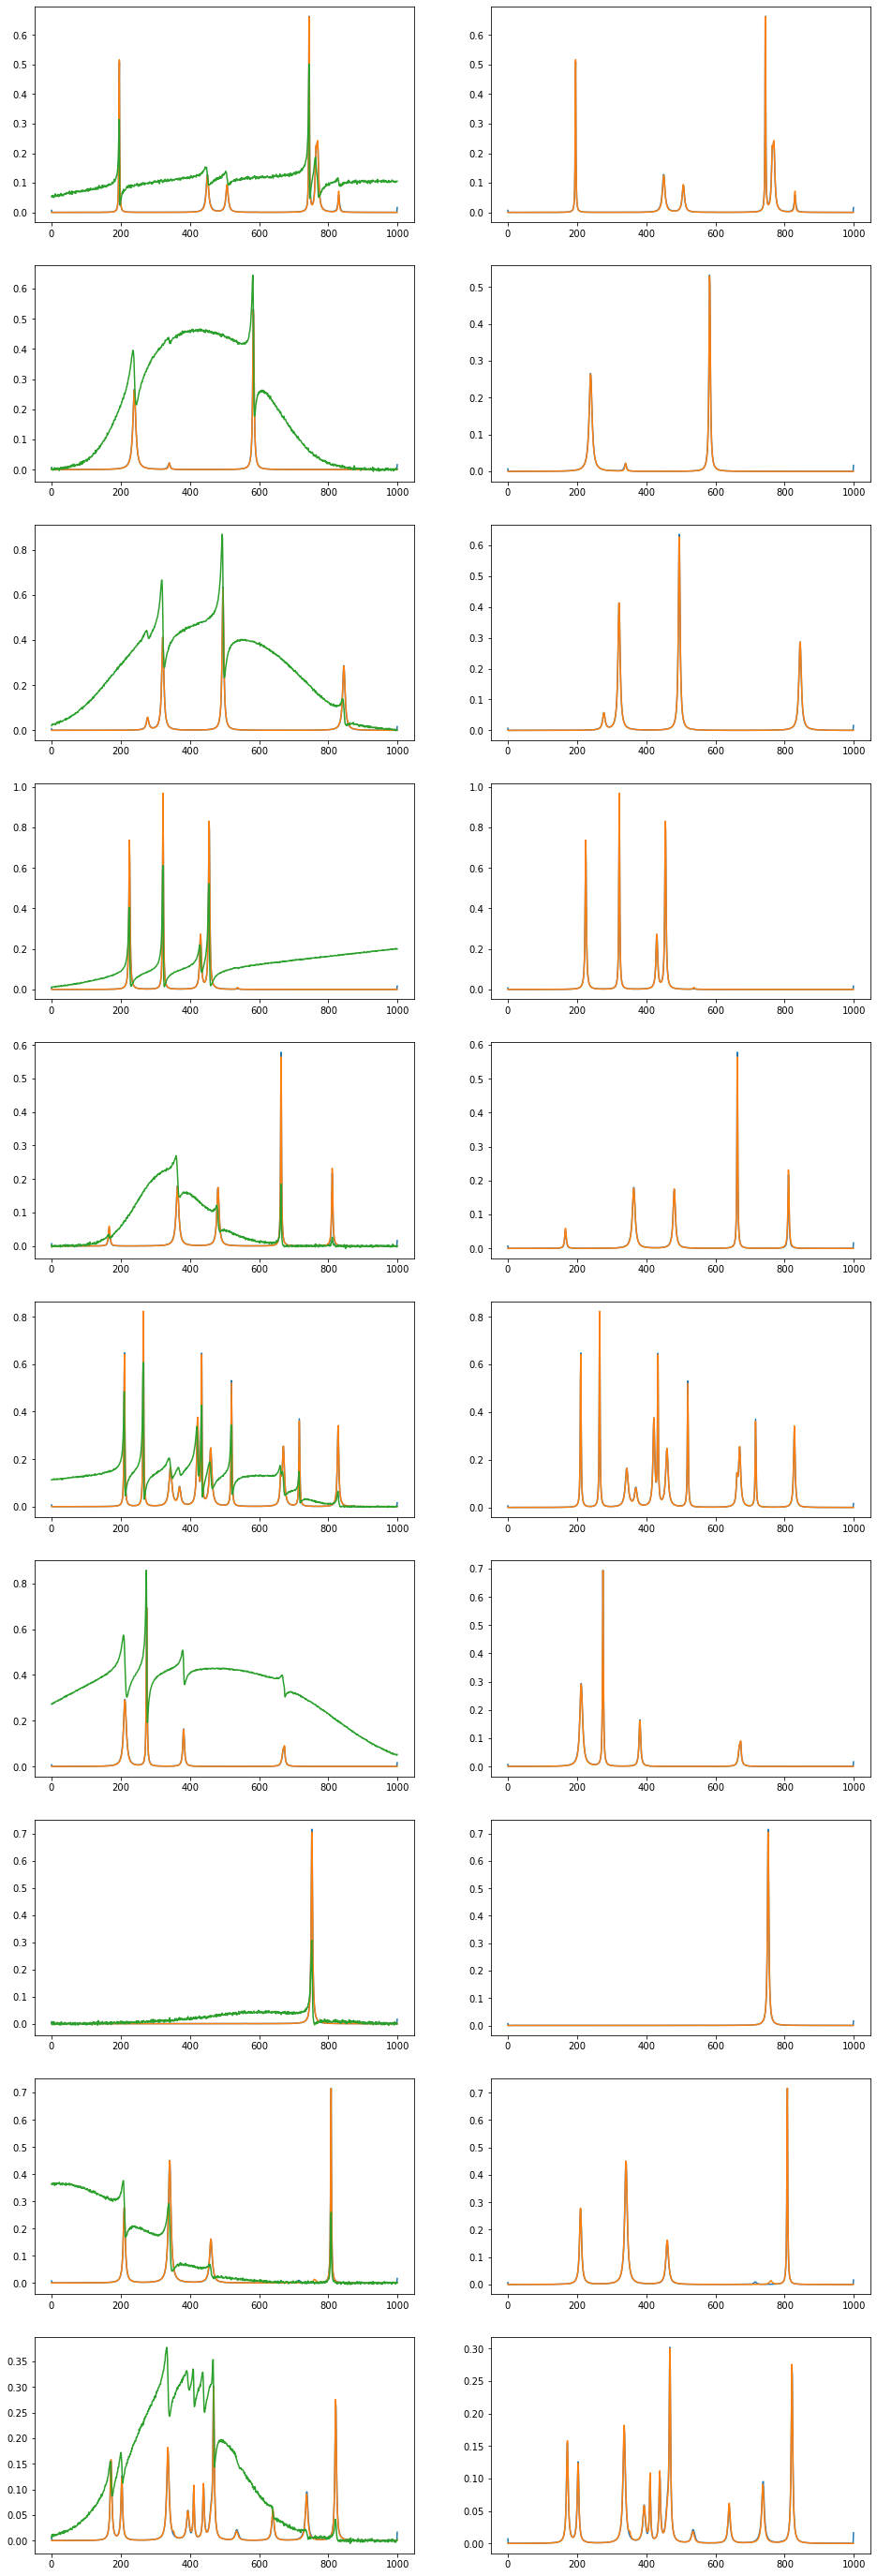

In [7]:
#test on 10 spectra from validation set
plt.figure(figsize=(16,50))
i = 0
n=10
m=20
with torch.no_grad():
    for ind in range(n, m):
        raman =  torch.Tensor(dataset_val[ind][0]).view(1,-1).squeeze(1).float().cuda()
        cars = torch.Tensor(dataset_val[ind][1]).view(1,-1).squeeze(1).float().cuda()
        outputs = model(cars)
        plt.subplot(10,2,i*2+1)
        plt.plot(outputs.data.cpu().numpy()[0])
        plt.plot(raman.data.cpu().numpy()[0])
        plt.plot(cars.data.cpu().numpy()[0])


        plt.subplot(10,2,i*2+2)
        plt.plot(outputs.data.cpu().numpy()[0])
        plt.plot(raman.data.cpu().numpy()[0])
        i += 1